In [51]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import gridspec
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from IPython import display

In [52]:
# 检测设备
device = "cuda" if torch.cuda.is_available() else "cpu"

In [53]:
device

'cuda'

In [54]:
"""
    图像预处理
        1. 转张量
"""
trans = transforms.Compose(transforms=[
    # 原本格式[0, 255] [H, W, C]
    # ToTensor会转换成[0, 1] [C, H, W]
    transforms.ToTensor(),
    # [0, 1]
    # [-1, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [55]:
# 加载图像
data = datasets.MNIST(root="data", train=True, transform=trans, download=True)

In [56]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [57]:
dataloader = DataLoader(dataset=data, batch_size=128, shuffle=True)

In [58]:
# 测试图像
for batch_X, batch_y in dataloader:
    print(batch_X.shape)
    print(batch_y.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [59]:
"""
    定义一个生成器
        - 造假图像的网络
            - 输入：一个向量（Z，noise，噪声，随机数, 比如：128维）
            - 输出：一个图像（[1, 28, 28]），一个向量（28 * 28）
"""
class Generator(nn.Module):
    # 784
    def __init__(self, in_features=128, out_features=28 * 28):
        super().__init__()
        self.linear1 = nn.Linear(in_features=in_features, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=28 * 28)
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.tanh(x)
        return x

In [60]:
"""
    定义一个生成器
        - 造假图像的网络
            - 输入：一个向量（Z，noise，噪声，随机数, 比如：128维）
            - 输出：一个图像（[1, 28, 28]），一个向量（28 * 28）
"""
class Generator1(nn.Module):
    # 784
    def __init__(self, in_features=128, out_features=28 * 28):
        super().__init__()
        self.linear1 = nn.Linear(in_features=in_features, out_features=28 * 28)
        # self.linear2 = nn.Linear(in_features=256, out_features=512)
        # self.linear3 = nn.Linear(in_features=512, out_features=28 * 28)
    def forward(self, x):
        x = self.linear1(x)
        # x = torch.relu(x)
        # x = self.linear2(x)
        x = torch.relu(x)
        # x = self.linear3(x)
        x = torch.tanh(x)
        return x

In [61]:
"""
    鉴别器
        - 判断真假！
        - 给你一个图像，你告诉我这是个真的还是假的？
        - 二分类算法！
"""
class Discriminator1(nn.Module):
    def __init__(self, in_features=28 * 28, out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features=in_features, out_features=out_features)
        # self.linear2 = nn.Linear(in_features=512, out_features=256)
        # self.linear3 = nn.Linear(in_features=256, out_features=32)
        # self.linear4 = nn.Linear(in_features=32, out_features=out_features)
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        # x = self.linear2(x)
        # x = torch.relu(x)
        # x = self.linear3(x)
        # x = torch.relu(x)
        # x = self.linear4(x)
        return x

In [62]:
"""
    鉴别器
        - 判断真假！
        - 给你一个图像，你告诉我这是个真的还是假的？
        - 二分类算法！
"""
class Discriminator(nn.Module):
    def __init__(self, in_features=28 * 28, out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features=in_features, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=32)
        self.linear4 = nn.Linear(in_features=32, out_features=out_features)
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.linear4(x)
        return x

In [63]:
"""
    构建模型
"""
# 定义一个生成器
generator = Generator(in_features=128, out_features=28 * 28)
generator.to(device=device)
# 定义一个鉴别器
discriminator = Discriminator(in_features=28 * 28, out_features=2)
discriminator.to(device=device)

# 定义一个生成器
generator1 = Generator1(in_features=128, out_features=28 * 28)
generator1.to(device=device)
# 定义一个鉴别器
discriminator1 = Discriminator1(in_features=28 * 28, out_features=2)
discriminator1.to(device=device)

Discriminator1(
  (linear1): Linear(in_features=784, out_features=2, bias=True)
)

In [64]:
"""
    优化器
        - 执行梯度下降
        - 2个网络，几个优化器？
        - 同时训练的吗？
"""
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

In [65]:
"""
    定义一个损失函数
"""

loss_fn = nn.CrossEntropyLoss()

In [66]:
"""
    训练轮次
"""
epochs = 1000

In [67]:
"""
    训练样本构建：
        - 真实图像：1
            - 来自于待模仿的对象
                - 手写数字
        - 假图像：0
            - 生成器生成的结果
                - 输入随机数，生成的假图像
"""
def get_real_data_labels(size):
    """
        获取真实数据的标签
    """
    labels = torch.ones(size, device=device, dtype=torch.long)
    return labels
    
def get_fake_data_labels(size):
    """
        获取假数据的标签
    """
    labels = torch.zeros(size, device=device, dtype=torch.long)
    return labels

In [68]:
"""
    随机获取一批随机数
"""
def get_noise(size):
    X = torch.randn(size, 128, device=device)
    return X

In [69]:
"""
    获取一批测试噪声
    num_test_samples = 16
"""
num_test_samples = 16
test_noise = get_noise(num_test_samples)

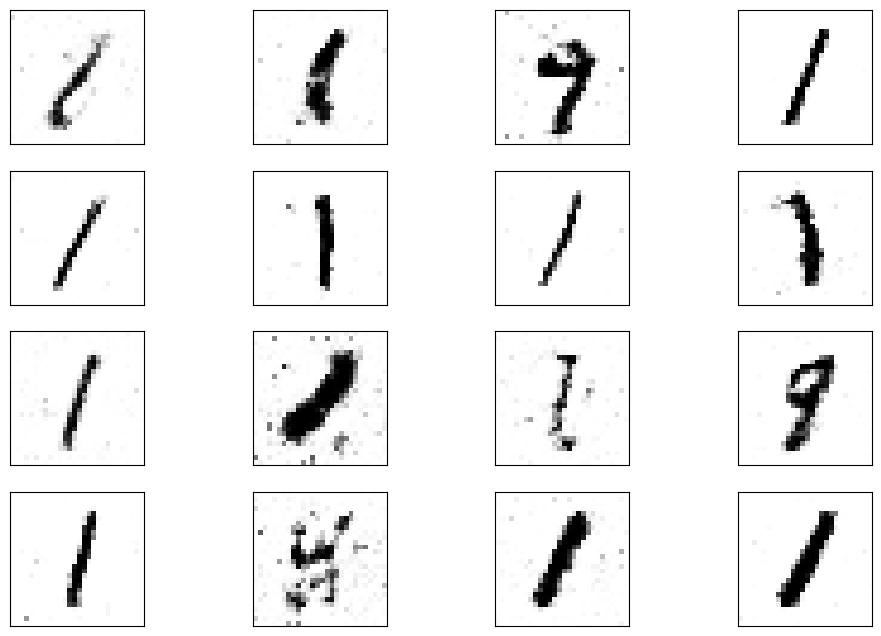

当前正在进行第108轮训练


KeyboardInterrupt: 

In [70]:
"""
    训练过程
"""
for epoch in range(1, epochs + 1):
    print(f"当前正在进行第{epoch}轮训练")
    # 逐批次训练
    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        # 1. 真实图像 
        real_data = batch_X.view(batch_X.size(0), -1).to(device=device)
        # 2. 给生成器准备的输入噪声
        noise = get_noise(batch_X.size(0)).to(device=device)
        # 把这部分计算从计算图中删掉
        # 得到一个常量假数据
        fake_data = generator(noise).detach()
        
        """
            互相踩在对方的肩上，一点点的进步！！！！！
        """
        """
            优化一步鉴别器
        """
        # 1. 训练过程
        d_optimizer.zero_grad()
        # 把真实数据交给鉴别器去鉴别
        real_pred = discriminator(real_data)
        # 计算真实数据产生的损失
        real_loss = loss_fn(real_pred, get_real_data_labels(real_data.size(0)))
        real_loss.backward()
        
        fake_pred = discriminator(fake_data)
        fake_loss = loss_fn(fake_pred, get_fake_data_labels(fake_data.size(0)))
        fake_loss.backward()
        # 鉴别器优化一步
        d_optimizer.step()

        """
            训练一步生成器
        """
        noise = get_noise(size=real_data.size(0))
        fake_pred = generator(noise)
        g_optimizer.zero_grad()
        # 临时冻结 鉴别器，只有
        for param in discriminator.parameters():
            param.requires_grad=False
        d_pred = discriminator(fake_pred)
        # 解除冻结 鉴别器
        for param in discriminator.parameters():
            param.requires_grad=True
        # 互相博弈的关键
        g_loss = loss_fn(d_pred, get_real_data_labels(d_pred.size(0)))
        g_loss.backward()
        g_optimizer.step()
    
    # 每训练一轮，看看训练结果
    with torch.no_grad():
        
        # 正向推理
        img_pred = generator(test_noise)
        img_pred = img_pred.view(img_pred.size(0), 28, 28).cpu().data
        
        # 画图
        display.clear_output(wait=True)
        
        # 设置画图的大小
        fig = plt.figure(1, figsize=(12, 8)) 
        # 划分为 4 x 4 的 网格
        gs = gridspec.GridSpec(4, 4)
        
        # 遍历每一个
        for i in range(4):
            for j in range(4):
                # 取每一个图
                X = img_pred[i * 4 + j, :, :]
                # 添加一个对应网格内的子图
                ax = fig.add_subplot(gs[i, j])
                # 在子图内绘制图像
                ax.matshow(X, cmap=plt.get_cmap("Greys"))
#                 ax.set_xlabel(f"{label}")
                ax.set_xticks(())
                ax.set_yticks(())
        plt.show()